In [ ]:
!pip install -q torch transformers transformers langchain sentence-transformers faiss-gpu openpyxl openai

In [ ]:
%reload_ext autoreload
%autoreload 2
%reload_ext dotenv
%dotenv

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from langchain_core.language_models import BaseChatModel
from datasets import Dataset

pd.set_option("display.max_colwidth", None)

# Intro to RAG

RAG, or Retrieval Augmented Generation, is an architecture that uses a pre-existing knowledge base to answer queries.

This process consists of two steps:

1. A Retriever, functioning like an internal search engine, identifies the most relevant documents from the knowledge base to respond to the query.
2. A Reader Language Model (LLM) reads these retrieved documents to produce an answer to the user’s query.

Here is the workflow:

<img src="RAG_graph.png" height="700">

💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

### Load your knowledge base

In [2]:
import datasets

ds = datasets.load_dataset("A-Roucher/huggingface_doc", split="train")

# 1. Build RAG System

## 1.1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns the most relevant documents from your knowledge base.

> For the knowledge base, we use Langchain vector databases since __it offers a convenient [FAISS](https://github.com/facebookresearch/faiss) index and allows us to keep document metadata throughout the processing__.

🛠️ __Options included:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

👷‍♀️ __More could be considered:__
- Try another chunking method, like semantic chunking
- Change the index used (here, FAISS)

### Building the vector database: preprocessing

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to have semantically relevant snippets: not too small to be sufficient for supporting an answer, and not too large too avoid diluting each idea.

> We use Langchain's `RecursiveCharacterTextSplitter`, which makes efficient use of code language detection to make better splits.

> 👀 Depending on your embedding model, the documents you are trying to embed might be truncated over 512 tokens: so you may want to visualize the length of your chunks.

💡 To help you tune this step, [this space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different chunking options affect the chunks you get.

In [ ]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


def split_documents(
    chunk_size: int, knowledge_base: List[LangchainDocument]
) -> List[LangchainDocument]:
    """
    Split documents into chunks of size `chunk_size` characters and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    return docs_processed


docs_processed = split_documents(1000, RAW_KNOWLEDGE_BASE)

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]

<Axes: >

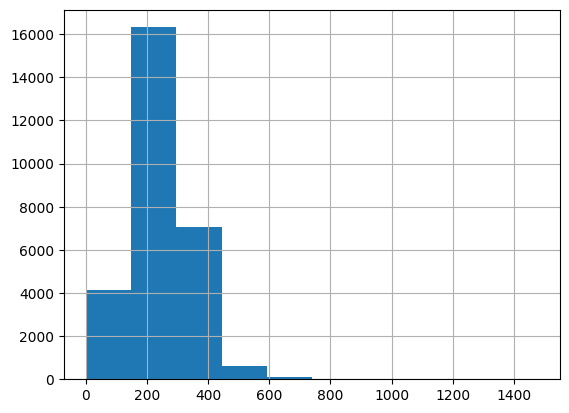

In [13]:
pd.Series(lengths).hist()

⬇️🚨 The cell below takes a few minutes to run on A10G!

In [53]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import os


def load_embeddings(
    langchain_docs: List[LangchainDocument],
    chunk_size: int,
    embedding_model_name: Optional[str] = "thenlper/gte-small",
) -> FAISS:
    """
    Creates a FAISS index from the given embedding model and documents. Loads the index directly if it already exists.

    Args:
        langchain_docs: list of documents
        chunk_size: size of the chunks to split the documents into
        embedding_model_name: name of the embedding model to use

    Returns:
        FAISS index
    """
    # load embedding_model
    embedding_model = HuggingFaceEmbeddings(
        model_name=embedding_model_name,
        multi_process=True,
        model_kwargs={"device": "cuda"},
        encode_kwargs={
            "normalize_embeddings": True
        },  # set True to compute cosine similarity
    )

    # Check if embeddings already exist on disk
    index_name = (
        f"index_chunk:{chunk_size}_embeddings:{embedding_model_name.replace('/', '~')}"
    )
    index_folder_path = f"./data/indexes/{index_name}/"
    if os.path.isdir(index_folder_path):
        return FAISS.load_local(
            index_folder_path,
            embedding_model,
            distance_strategy=DistanceStrategy.COSINE,
        )

    else:
        print("Index not found, generating it...")
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=100,
            add_start_index=True,
            separators=["\n\n", "\n", ".", " ", ""],
        )
        docs_processed = []
        for doc in langchain_docs:
            docs_processed += text_splitter.split_documents([doc])

        knowledge_index = FAISS.from_documents(
            docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
        )
        knowledge_index.save_local(index_folder_path)
        return knowledge_index

### Retriever
- When the vector database is built, the retriever works by embedding the user query and searching for the top `k` most similar documents in the vector database.
- Here, this operation is transparently performed by the method `KNOWLEDGE_INDEX.similarity_search(query)`

In [40]:
KNOWLEDGE_INDEX = load_embeddings(
    RAW_KNOWLEDGE_BASE, chunk_size=1500, model_name="thenlper/gte-small"
)
print("\nStarting retrieval:")
docs = KNOWLEDGE_INDEX.similarity_search(query="How to create a pipeline object?", k=5)
print(docs[0].page_content)
print(docs[0].metadata)

Index not found, generating it...

Starting retrieval:
Start by inheriting the base class `Pipeline` with the 4 methods needed to implement `preprocess`,
`_forward`, `postprocess`, and `_sanitize_parameters`.


```python
from transformers import Pipeline


class MyPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "maybe_arg" in kwargs:
            preprocess_kwargs["maybe_arg"] = kwargs["maybe_arg"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, inputs, maybe_arg=2):
        model_input = Tensor(inputs["input_ids"])
        return {"model_input": model_input}

    def _forward(self, model_inputs):
        # model_inputs == {"model_input": model_input}
        outputs = self.model(**model_inputs)
        # Maybe {"logits": Tensor(...)}
        return outputs

    def postprocess(self, model_outputs):
        best_class = model_outputs["logits"].softmax(-1)
        return best_class
```

The structure of this b

## 1.2 Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved documents to formulate its answer.__

🛠️ Here we tried the following options to improve results:
- Switch reranking on/off
- Change the reader model

💡 Many options could be considered here to further improve the results:
- Tune the prompt template
- Compression the retrieved context to keep only the relevant parts to answer the query.
- Extend the RAG system to make it more user friendly:
    - cite source
    - make conversational

In [39]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context, 
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

In [ ]:
from transformers import pipeline

llm = pipeline(
    "text-generation", model="HuggingFaceH4/zephyr-7b-beta", max_new_tokens=3500
)

llm("Ok,")

In [41]:
import requests
import os

API_URL = "https://ytjpei7t003tedav.us-east-1.aws.endpoints.huggingface.cloud"

headers = {
    "Authorization": f"Bearer {os.getenv('HF_TOKEN')}",
    "Content-Type": "application/json",
}


def get_llm_answer(question):
    payload = {
        "inputs": question,
        "max_new_tokens": 3000,
    }
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [42]:
from ragatouille import RAGPretrainedModel


def apply_reranking(
    question: str,
    documents: List[LangchainDocument],
    reranker: RAGPretrainedModel,
    num_docs_final: Optional[int] = 5,
) -> List[LangchainDocument]:
    # keep only the top k documents
    documents_sorted_in_order = reranker.rerank(question, documents, k=num_docs_final)

    # Even and odd documents are ordered in opposite directions to put the most relevant documents at the beginning and end
    documents_even = documents_sorted_in_order[::2]
    documents_odd = documents_sorted_in_order[1::2]
    documents = documents_even + documents_odd[::-1]
    return documents

In [43]:
def answer_with_rag(
    question: str,
    llm: BaseChatModel,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 7,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]

    # Optionally rerank results
    if reranker:
        apply_reranking(
            question, relevant_docs, reranker, num_docs_final=num_docs_final
        )

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"{str(i)}: " + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(context=context, question=question)

    # Redact an answer
    output = llm(final_prompt)
    try:
        answer = output[0]["generated_text"]
    except:
        # Retry with shorter contect
        context = "\nExtracted documents:\n"
        context += "".join(
            [f"{str(i)}: " + doc for i, doc in enumerate(relevant_docs[:-1])]
        )

        final_prompt = RAG_PROMPT_TEMPLATE.format(context=context, question=question)

        # Redact an answer
        output = llm(final_prompt)
        answer = output[0]["generated_text"]

    return answer, relevant_docs

## 1.3 Test
Let's see how our RAG pipeline answers a user query.

In [44]:
question = "how to create a pipeline object?"
answer, relevant_docs = answer_with_rag(
    question, get_llm_answer, KNOWLEDGE_INDEX, reranker=None
)

In [45]:
print("Answer:")
print(f"{answer}")
print("\n\nSource documents:")
for doc in relevant_docs:
    print(doc)

Answer:
To create a pipeline object, you need to inherit from the base `Pipeline` class provided by the `transformers` library. This involves defining four methods: `preprocess`, `_forward`, `postprocess`, and `_sanitize_parameters`. Here's an example:

```python
from transformers import Pipeline

class MyPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}


Source documents:
Start by inheriting the base class `Pipeline` with the 4 methods needed to implement `preprocess`,
`_forward`, `postprocess`, and `_sanitize_parameters`.


```python
from transformers import Pipeline


class MyPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "maybe_arg" in kwargs:
            preprocess_kwargs["maybe_arg"] = kwargs["maybe_arg"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, inputs, maybe_arg=2):
        model_input = Tensor(inputs["input_ids"])
        return {"model_input": 

# 2. Benchmarking the RAG system

Since there are so many options to tune with a big impact on parameters, benchmarking the RAG system is crucial.

But to do so we will need:
- an evaluation dataset
- an evaluator to compute the accuracy of our system.

➡️ It turns out, we can use LLMs to help us all along the way!
- the evaluation dataset will be synthetically generated by an LLM 🤖, and questions will be filtered out by other LLMs 🤖
- the evaluation will then be run on this synthetic dataset by a LLM-as-a-judge agent 🤖.

## 2.1 Build a synthetic dataset for evaluation
We first build a synthetic dataset of questions and associated contexts.

The idea is to randomly get elements from our knowledge base, and ask a LLM to generate questions based on these documents.

In [ ]:
LOAD_PREGENERATED_EVALUATION_DATASET = True

if LOAD_PREGENERATED_EVALUATION_DATASET:
    eval_dataset = datasets.load_dataset("A-Roucher/huggingface_doc_qa_eval")

### Prepare source documents

In [ ]:
if not LOAD_PREGENERATED_EVALUATION_DATASET:
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.docstore.document import Document as LangchainDocument

    langchain_docs = [
        LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
        for doc in tqdm(ds)
    ]

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000,
        chunk_overlap=200,
        add_start_index=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in langchain_docs:
        docs_processed += text_splitter.split_documents([doc])

### Setup agents for question generation

In [ ]:
if not LOAD_PREGENERATED_EVALUATION_DATASET:
    from langchain.prompts import ChatPromptTemplate
    from langchain.chat_models import ChatOpenAI

    QA_generation_prompt = """
    Your task is to write a factoid question and an answer given a context.
    Your factoid question should be answerable with a specific, concise piece of factual information from the context.
    Your factoid question should be formulated in the same style as questions users could ask in a search engine.
    This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

    Provide your answer as follows:

    Output:::
    Factoid question: (your factoid question)
    Answer: (your answer to the factoid question)

    Now here is the context.

    Context: {context}\n
    Output:::"""

    chat_model = ChatOpenAI(model="gpt-4-1106-preview")
    QA_generation_prompt = ChatPromptTemplate.from_template(QA_generation_prompt)
    QA_generation_agent = QA_generation_prompt | chat_model

In [ ]:
import random

if not LOAD_PREGENERATED_EVALUATION_DATASET:
    N_GENERATIONS = 30

    print(f"Generating {N_GENERATIONS} QA couples...")
    outputs = []
    for context in tqdm(random.sample(langchain_docs, N_GENERATIONS)):
        # Generate QA couple
        output_QA_couple = QA_generation_agent.invoke(
            {"context": context.page_content}
        ).content
        try:
            question = output_QA_couple.split("Factoid question: ")[1].split(
                "Answer: "
            )[0]
            answer = output_QA_couple.split("Answer: ")[1]
            outputs.append(
                {
                    "context": context.page_content,
                    "question": question,
                    "answer": answer,
                    "source_doc": context.metadata["source"],
                }
            )
        except:
            continue

### Setup critique agents
We now build and run the critique agents that will filter out questions generated by the previous LLM agent.

In [ ]:
if not LOAD_PREGENERATED_EVALUATION_DATASET:
    question_relatedness_critique_prompt = """
    You will be given a context and a question.
    Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here are the question and context.

    Question: {question}\n
    Context: {context}\n
    Answer::: """

    question_relevance_critique_prompt = """
    You will be given a question.
    Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

    Rating must be minimum, i.e. 1, if the questions refers to a particular setting, like 'in the context' or 'in the document'.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here is the question.

    Question: {question}\n
    Answer::: """

    question_standalone_critique_prompt = """
    You will be given a question.
    Your task is to provide a 'total rating' representing how context-independant this question is.
    Give your answer on a scale of 1 to 5, where 1 means that the question only makes sense in a specific context, and 5 means that the question makes sense by itself.
    For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
    The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here is the question.

    Question: {question}\n
    Answer::: """

    question_relatedness_critique_prompt = ChatPromptTemplate.from_template(
        question_relatedness_critique_prompt
    )
    question_relatedness_critique_agent = (
        question_relatedness_critique_prompt | chat_model
    )

    question_relevance_critique_prompt = ChatPromptTemplate.from_template(
        question_relevance_critique_prompt
    )
    question_relevance_critique_agent = question_relevance_critique_prompt | chat_model

    question_standalone_critique_prompt = ChatPromptTemplate.from_template(
        question_standalone_critique_prompt
    )
    question_standalone_critique_agent = (
        question_standalone_critique_prompt | chat_model
    )

In [ ]:
if not LOAD_PREGENERATED_EVALUATION_DATASET:
    print("Generating critique for each QA couple...")
    for output in tqdm(outputs):
        # Critique the generated QA couple
        question_relatedness_evaluation = question_relatedness_critique_agent.invoke(
            {"context": output["context"], "question": output["question"]}
        ).content
        question_relevance_evaluation = question_relevance_critique_agent.invoke(
            {"question": output["question"]}
        ).content
        question_standalone_evaluation = question_standalone_critique_agent.invoke(
            {"question": output["question"]}
        ).content

        try:
            relatedness_score = int(
                question_relatedness_evaluation.split("Total rating: ")[1][0]
            )
            relatedness_eval = question_relatedness_evaluation.split("Total rating: ")[
                0
            ].split("Evaluation: ")[1]
            relevance_score = int(
                question_relevance_evaluation.split("Total rating: ")[1][0]
            )
            relevance_eval = question_relevance_evaluation.split("Total rating: ")[
                0
            ].split("Evaluation: ")[1]
            standalone_score = int(
                question_standalone_evaluation.split("Total rating: ")[1][0]
            )
            standalone_eval = question_standalone_evaluation.split("Total rating: ")[
                0
            ].split("Evaluation: ")[1]
            output.update(
                {
                    "relatedness_score": relatedness_score,
                    "relatedness_eval": relatedness_eval,
                    "relevance_score": relevance_score,
                    "relevance_eval": relevance_eval,
                    "standalone_score": standalone_score,
                    "standalone_eval": standalone_eval,
                }
            )
        except:
            continue

Filter down questions on the chosen criteria:

In [ ]:
if not LOAD_PREGENERATED_EVALUATION_DATASET:
    import pandas as pd

    pd.set_option("display.max_colwidth", None)

    generated_questions = pd.DataFrame.from_dict(outputs)
    display(generated_questions.head())
    generated_questions = generated_questions.loc[
        (generated_questions["relatedness_score"] >= 4)
        & (generated_questions["relevance_score"] >= 3)
        & (generated_questions["standalone_score"] >= 4)
    ]
    generated_questions.to_excel("qa_eval.xlsx")
    display(generated_questions.head())

    eval_dataset = datasets.Dataset.from_pandas(
        generated_questions, split="train", preserve_index=False
    )

Now the synthetic evaluation dataset is complete! We can evaluate different RAG systems on this evaluation dataset.

## 2.2 Run tests

In [46]:
import json


def run_rag_tests(
    eval_dataset: Dataset,
    llm: BaseChatModel,
    knowledge_index: FAISS,
    output_file: str,
    reranker: Optional[RAGPretrainedModel] = None,
    verbose: Optional[bool] = True,
):
    try:  # load previous generations if they exist
        with open(output_file, "r") as f:
            outputs = json.load(f)
    except:
        outputs = []
    for example in tqdm(eval_dataset["train"]):
        question = example["question"]
        if question in [output["question"] for output in outputs]:
            continue

        answer, relevant_docs = answer_with_rag(
            question, llm, knowledge_index, reranker=reranker
        )
        if verbose:
            print(":::::::")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example["answer"]}')
        outputs.append(
            {
                "question": question,
                "true_answer": example["answer"],
                "source_doc": example["source_doc"],
                "generated_answer": answer,
                "retrieved_docs": [doc for doc in relevant_docs],
            }
        )

        with open(output_file, "w") as f:
            json.dump(outputs, f)

In [47]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [48]:
from langchain.chat_models import ChatOpenAI

eval_chat_model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0)
evaluator_name = "GPT4"


def evaluate_answers(
    answer_path: str,
    eval_chat_model: BaseChatModel,
    evaluator_name: str,
    evaluation_prompt_template: ChatPromptTemplate,
) -> None:
    try:  # load previous generations if they exist
        with open(answer_path, "r") as f:
            answers = json.load(f)
    except:
        answers = []

    for experiment in tqdm(answers):
        if f"eval_score_{evaluator_name}" in experiment:
            continue

        eval_prompt = evaluation_prompt_template.format_messages(
            instruction=experiment["question"],
            response=experiment["generated_answer"],
            reference_answer=experiment["true_answer"],
        )
        eval_result = eval_chat_model.invoke(eval_prompt)
        feedback, score = [
            item.strip() for item in eval_result.content.split("[RESULT]")
        ]
        experiment[f"eval_score_{evaluator_name}"] = score
        experiment[f"eval_feedback_{evaluator_name}"] = feedback

        with open(answer_path, "w") as f:
            json.dump(answers, f)

In [55]:
RAG_SETTINGS = {}
for chunk_size in [500, 700, 1000, 1500]:
    for embeddings in ["thenlper/gte-small", "BAAI/bge-base-en-v1.5"]:
        for rerank in [True, False]:
            RAG_SETTINGS[
                f"chunk:{chunk_size}_embeddings:{embeddings.replace('/', '~')}_rerank:{rerank}_reader:mistral-7b"
            ] = {
                "retriever": {
                    "chunk_size": chunk_size,
                    "embeddings": embeddings,
                },
                "reader": {
                    "rerank_results": rerank,
                },
            }

In [ ]:
for settings_name, settings in RAG_SETTINGS.items():
    print(f"Running evaluation for {settings_name}:")
    output_file_name = f"./output/rag_{settings_name}.json"

    print("Loading knowledge base embeddings...")
    knowledge_index = load_embeddings(
        RAW_KNOWLEDGE_BASE,
        chunk_size=settings["retriever"]["chunk_size"],
        embedding_model_name=settings["retriever"]["embeddings"],
    )

    print("Running RAG...")
    if settings["reader"]["rerank_results"]:
        reranker = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
    else:
        reranker = None
    run_rag_tests(
        eval_dataset=eval_dataset,
        llm=get_llm_answer,
        knowledge_index=knowledge_index,
        output_file=output_file_name,
        reranker=reranker,
        verbose=False,
    )

    print("Running evaluation...")
    evaluate_answers(
        output_file_name,
        eval_chat_model,
        evaluator_name,
        evaluation_prompt_template,
    )

## 2.3 Visualize results

In [58]:
import glob

results = []
for file in glob.glob("output/*.json"):
    print(file)
    with open(file, "r") as f:
        sub_df = pd.read_json(f)
        sub_df["settings"] = file.split("rag_")[1].split(".json")[0]
        results.append(sub_df)

results_df = pd.concat(results)

output/rag_chunk:1500_embeddings:thenlper~gte-small_rerank:False_reader:mistral-7b.json
output/rag_chunk:700_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader:mistral-7b.json
output/rag_chunk:1000_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader:mistral-7b.json
output/rag_chunk:500_embeddings:thenlper~gte-small_rerank:False_reader:mistral-7b.json
output/rag_chunk:700_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader:mistral-7b.json
output/rag_chunk:500_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader:mistral-7b.json
output/rag_chunk:300_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader:mistral-7b.json
output/rag_chunk:500_embeddings:thenlper~gte-small_rerank:True_reader:mistral-7b.json
output/rag_chunk:1000_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader:mistral-7b.json
output/rag_chunk:700_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader:mixtral-8x7b.json
output/rag_chunk:1500_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader:mistral-7b.json
output/rag_chunk:5

In [59]:
def interpret_result(x):
    try:
        return (int(x) - 1) / 4
    except:
        return 0


results_df["normalized_score"] = results_df["eval_score_GPT4"].apply(interpret_result)

In [87]:
scores = results_df.groupby("settings")["normalized_score"].mean().sort_values() * 100
scores = scores.rename(
    index={
        "chunk:1500_embeddings:thenlper~gte-small_rerank:False_reader:mistral-7b": "Baseline RAG",
        "chunk:500_embeddings:thenlper~gte-small_rerank:False_reader:mistral-7b": "+ Tune chunk size",
        "chunk:500_embeddings:thenlper~gte-small_rerank:True_reader:mistral-7b": "+ Rerank results",
        "chunk:500_embeddings:BAAI~bge-base-en-v1.5_rerank:False_reader:mistral-7b": "+ Better embeddings",
        "chunk:700_embeddings:BAAI~bge-base-en-v1.5_rerank:True_reader:mixtral-8x7b": "+ Better reader LLM",
    }
)
scores = scores.loc[
    [
        "Baseline RAG",
        "+ Tune chunk size",
        "+ Rerank results",
        "+ Better embeddings",
        "+ Better reader LLM",
    ]
]

In [93]:
import plotly.express as px

fig = px.bar(
    scores,
    color=scores,
    text=scores,
    labels={
        "value": "Accuracy",
        "settings": "Configuration",
    },
    color_continuous_scale="bluered",
)
fig.update_layout(
    width=1000,
    height=600,
    barmode="group",
    yaxis_range=[0, 100],
    title="Accuracy of different RAG configurations",
)
fig.layout.yaxis.ticksuffix = "%"
fig.update_coloraxes(showscale=False)
fig.update_traces(texttemplate="%{y:.0f}", textposition="outside")
fig.show()

<img src="RAG_options_accuracy.png" height="500">